# ** If you are running on Binder **

You should:
- Launch a new Desktop tab by going to New -> Desktop in the index page ([screenshot](../_images/binder-desktop.png))

- then uncomment and execute the code below:

In [ ]:
#import os
#os.environ['DISPLAY'] = ':1.0'

# Preamble

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%gui qt

# Segmentation

--------------

## Separating an image into one or more regions of interest.

Everyone has heard or seen Photoshop or a similar graphics editor take a person from one image and place them into another.  The first step of doing this is *identifying where that person is in the source image*.

In popular culture, the Terminator's vision segments humans:

<img src="../workshops/archived/2014-scipy/images/terminator-vision.png" width="700px"/>

### Segmentation contains two major sub-fields

* **Supervised** segmentation: Some prior knowledge, possibly from human input, is used to guide the algorithm.  Supervised algorithms currently included in scikit-image include
  *  Thresholding algorithms which require user input (`skimage.filters.threshold_*`)
  * `skimage.segmentation.random_walker`
  * `skimage.segmentation.active_contour`
* **Unsupervised** segmentation: No prior knowledge.  These algorithms attempt to subdivide into meaningful regions automatically.  The user may be able to tweak settings like number of regions.
  *  Thresholding algorithms which require no user input.
  * `skimage.segmentation.slic`
  * `skimage.segmentation.watershed`
  * `skimage.segmentation.chan_vese`
  * `skimage.segmentation.felzenszwalb`
  * `skimage.segmentation.quickshift`


First, some standard imports and a helper function to display our results

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import napari

import skimage.data as data
import skimage.segmentation as seg
from skimage import filters
from skimage import draw
from skimage import color
from skimage import exposure

## Thresholding

In some images, global or local contrast may be sufficient to separate regions of interest.  Simply choosing all pixels above or below a certain *threshold* may be sufficient to segment such an image.

Let's try this on an image of a textbook.

In [3]:
text = data.page()

viewer = napari.view_image(text);

### Histograms

A histogram simply plots the frequency (number of times) values within a certain range appear against the data values themselves.  It is a powerful tool to get to know your data - or decide where you would like to threshold.

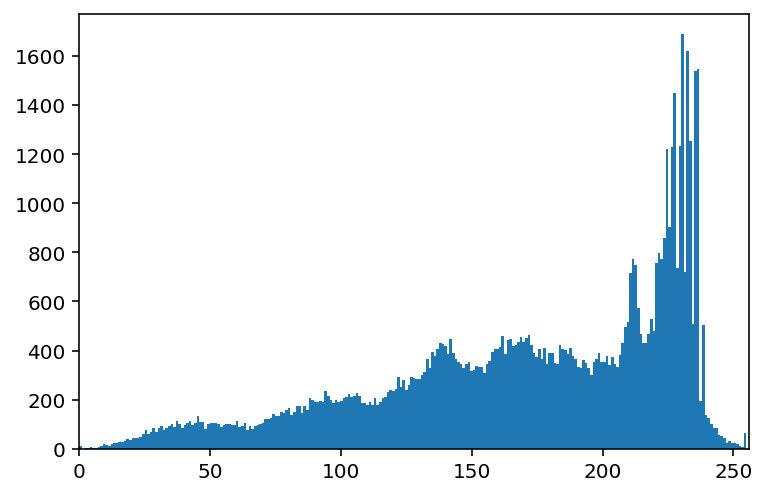

In [4]:
fig, ax = plt.subplots(1, 1)
ax.hist(text.ravel(), bins=256, range=[0, 255])
ax.set_xlim(0, 256);

### Experimentation: supervised thresholding

Try simple NumPy methods and a few different thresholds on this image.  Because *we* are setting the threshold, this is *supervised* segmentation.

In [7]:
text_segmented = text < 75 # your code here

viewer.add_labels(text_segmented)

<Labels layer 'text_segmented [2]' at 0x7ffe959bb580>

Not ideal results!  The shadow on the left creates problems; no single global value really fits.

What if we don't want to set the threshold every time?  There are several published methods which look at the histogram and choose what should be an optimal threshold without user input.  These are unsupervised.  

### Experimentation: unsupervised thresholding

Here we will experiment with a number of automatic thresholding methods available in scikit-image.  Because these require no input beyond the image itself, this is *unsupervised* segmentation.

These functions generally return the threshold value(s), rather than applying it to the image directly.

Try `otsu` and `li`, then take a look at `local` or `sauvola`.

In [10]:
text_auto_threshold = filters.threshold_sauvola(text)  # Hit tab with the cursor after the underscore, try several methods

viewer.add_labels(text < text_auto_threshold)
print(text_auto_threshold)

[[108.75710369 108.60194839 108.52145137 ... 191.2        191.2
  191.2       ]
 [108.66960051 108.54187714 108.49130179 ... 191.2        191.2
  191.2       ]
 [108.49725763 108.37997492 108.35033375 ... 191.2        191.2
  191.2       ]
 ...
 [ 47.5786972   47.52926261  47.9165988  ... 181.4201307  181.34251703
  181.20671373]
 [ 46.91156208  46.90314596  47.28186956 ... 181.19155306 181.08267335
  180.90771194]
 [ 46.52779329  46.52235842  46.90625596 ... 181.19155306 181.08267335
  180.90771194]]


In [12]:
segmented_text = text < text_auto_threshold

In [13]:
segmented_text.shape

(191, 384)

In [14]:
segmented_text.dtype

dtype('bool')

In [15]:
from skimage import measure

In [16]:
labeled_text = measure.label(segmented_text)

In [17]:
labeled_text.dtype

dtype('int64')

In [18]:
labeled_text.max()

281

In [19]:
viewer_text = napari.Viewer()
viewer_text.add_image(text)
viewer_text.add_labels(labeled_text)

<Labels layer 'labeled_text' at 0x7ffe9741d820>

## Supervised segmentation

Thresholding can be useful, but is rather basic and a high-contrast image will often limit its utility.  For doing more fun things - like removing part of an image - we need more advanced tools.

For this section, we will use the `astronaut` image and attempt to segment Eileen Collins' head using supervised segmentation.

In [11]:
# Our source image
astronaut = data.astronaut()
viewer = napari.view_image(astronaut)

The contrast is pretty good in this image for her head against the background, so we will simply convert to grayscale with `rgb2gray`.

In [20]:
astronaut_gray = color.rgb2gray(astronaut)
viewer.add_image(astronaut_gray);

We will use two methods, which segment using very different approaches:

* **Active Contour**: Initializes using a user-defined contour or line, which then is attracted to edges and/or brightness.  Can be tweaked for many situations, but mixed contrast may be problematic.
* **Random walker**: Initialized using any labeled points, fills the image with the label that seems least distant from the origin point (on a path weighted by pixel differences).  Tends to respect edges or step-offs, and is surprisingly robust to noise.  Only one parameter to tweak.

### Active contour segmentation

We must have a set of initial parameters to 'seed' our segmentation this.  Let's draw a circle around the astronaut's head to initialize the snake.

This could be done interactively, with a GUI, but for simplicity we will start at the point [100, 220] and use a radius of 100 pixels.  Just a little trigonometry in this helper function...

In [21]:
def circle_points(resolution, center, radius):
    """
    Generate points defining a circle on an image.
    """
    radians = np.linspace(0, 2*np.pi, resolution)
    r = center[0] + radius*np.sin(radians)
    c = center[1] + radius*np.cos(radians)
    
    return np.stack([r, c], axis=1)

# Exclude last point because a closed path should not have duplicate points
outer_points = circle_points(200, [100, 220], 100)[:-1]

In [25]:
snake = seg.active_contour(
    astronaut_gray,
    outer_points,
    alpha=0.1,
    #beta=0.01,
    coordinates='rc',
)

In [26]:
viewer.add_shapes(
    [outer_points],
    name='initial points',
    edge_color='red',
    face_color=[(0,0,0,0)],
    edge_width=2,
    shape_type='polygon'
)
viewer.add_shapes(
    [snake],
    name='active contour',
    edge_color='blue',
    face_color=[(0,0,0,0)],
    edge_width=2,
    shape_type='polygon'
)


<Shapes layer 'active contour' at 0x7ffe97093e80>

That didn't do much!

**Exercise:**

Go back and read the documentation of `seg.active_contour`, and change some parameters to see whether you can get a good contour. 

*Tip:* change parameters logarithmically (10, 1, 0.1, 0.01, ...) to make sure you are in the right order of magnitude. *Then* refine linearly.

### Random walker

One good analogy for random walker uses graph theory.  

* The distance from each pixel to its neighbors is weighted by how similar their values are; the more similar, the lower the cost is to step from one to another
* The user provides some seed points
* The algorithm finds the cheapest paths from each point to each seed value.  
* Pixels are labeled with the cheapest/lowest path.

We will re-use the seed values from our previous example.

In [27]:
astronaut_seeds = np.zeros(astronaut_gray.shape, dtype=np.uint8)

The random walker algorithm expects a label image as input.  Any label above zero will be treated as a seed; all zero-valued locations will be filled with labels from the positive integers available.

There is also a masking feature where anything labeled -1 will never be labeled or traversed, but we will not use it here.

In [28]:
inner = draw.circle_perimeter(100, 220, 25)

astronaut_seeds[inner] = 1
astronaut_seeds[tuple(outer_points.astype(int).T)] = 2

viewer.add_labels(astronaut_seeds);

In [38]:
astronaut_rw = seg.random_walker(astronaut_gray, astronaut_seeds,
                                beta=2600)

In [39]:
viewer.add_labels(astronaut_rw)

<Labels layer 'astronaut_rw' at 0x7ffe99b3f8e0>

**Exercise:**

Again, the default random walker parameters have let us down! Look at the documentation for `seg.random_walker` and play with the parameters to segment the astronaut's head.

## Unsupervised segmentation

Sometimes, human input is not possible or feasible - or, perhaps your images are so large that it is not feasible to consider all pixels simultaneously.  Unsupervised segmentation can then break the image down into several sub-regions, so instead of millions of pixels you have tens to hundreds of regions.

### SLIC

There are many analogies to machine learning in unsupervised segmentation.  Our first example directly uses a common machine learning algorithm under the hood - K-Means.

In [49]:
# SLIC works in color, so we will use the original astronaut
astronaut_slic = seg.slic(astronaut, n_segments=200,
                          start_label=1, compactness=40)

In [42]:
seg.slic?

In [50]:
# label2rgb replaces each discrete label with the average interior color
viewer.add_labels(astronaut_slic)

<Labels layer 'astronaut_slic' at 0x7ffe83b36220>

**Exercise:**

The results show some promise, but there are still leaks between real regions. As before, tweak the parameters until the segmentation contains the astronaut's head. It's ok if more than one region contains the head, but background regions should not "bleed into" the head.

We've reduced this image from 512 $\times$ 512 = 262,000 pixels down to 100 regions. This makes it much easier to finish the segmentation interactively, for example.

### Watershed

Watershed segmentation requires an image to have high values in between different objects, and low within the objects. *What does this remind you of?*

To understand watershed, think of the image as a landscape. When a drop lands somewhere on the image, it rolls down the image landscape to a low point. The set of points in the image that all land in the same point is called a *watershed basin*.

As a smoothing technique, the watershed method is usually *seeded* with markers, and basins can then only belong to one of the given markers. Basins that don't have a marker end up merged to a neighboring basin with the lowest separating ridge.

**Exercise:**

Use `segmentation.watershed` to generate a segmentation of the `data.coins` images. You may need to preprocess the image first.